# Deep Learning - Disease identification (Potato)

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Import Libraries</span>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Data Loading</span>

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"./PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Exploratory Data Analysis (EDA) </span>

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Exploratory Data Analysis (EDA) </span>

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 1 1 0 1 2 1 0 1 1 1 0 1 2 1 1 1 0 0 0 1 0 0 1 0 0 0]


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[136. 133. 144.]
  [135. 132. 143.]
  [135. 132. 143.]
  ...
  [ 90.  82.  95.]
  [ 92.  84.  97.]
  [ 95.  87. 100.]]

 [[141. 138. 149.]
  [141. 138. 149.]
  [141. 138. 149.]
  ...
  [ 91.  83.  96.]
  [ 92.  84.  97.]
  [ 95.  87. 100.]]

 [[144. 141. 152.]
  [145. 142. 153.]
  [146. 143. 154.]
  ...
  [ 92.  84.  97.]
  [ 92.  84.  97.]
  [ 95.  87. 100.]]

 ...

 [[139. 132. 139.]
  [139. 132. 139.]
  [141. 134. 141.]
  ...
  [ 76.  65.  73.]
  [ 84.  73.  81.]
  [ 91.  80.  88.]]

 [[137. 130. 137.]
  [137. 130. 137.]
  [138. 131. 138.]
  ...
  [ 81.  70.  78.]
  [ 80.  69.  77.]
  [ 79.  68.  76.]]

 [[136. 129. 136.]
  [135. 128. 135.]
  [137. 130. 137.]
  ...
  [ 91.  80.  88.]
  [ 87.  76.  84.]
  [ 79.  68.  76.]]]


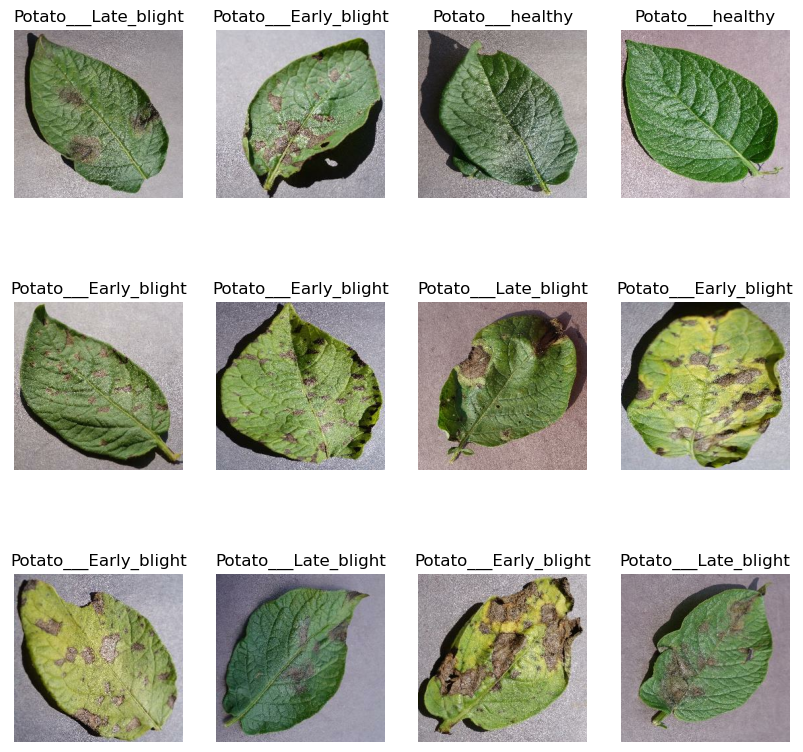

In [13]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Data Splitting </span>

In [20]:
train_size = 0.8

train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

len(test_ds)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<span style="font-size: 24px; color: blue; font-style: italic; font-weight: bold;">Model Training</span>

In [23]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    


])

model.build(input_shape=input_shape)

C:\Users\Maddy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4310 - loss: 0.9661 - val_accuracy: 0.7083 - val_loss: 0.7642
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6483 - loss: 0.7255 - val_accuracy: 0.8177 - val_loss: 0.4060
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7923 - loss: 0.4777 - val_accuracy: 0.8438 - val_loss: 0.3394
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8371 - loss: 0.3717 - val_accuracy: 0.8854 - val_loss: 0.2698
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8812 - loss: 0.3036 - val_accuracy: 0.9271 - val_loss: 0.1826
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8991 - loss: 0.2428 - val_accuracy: 0.8802 - val_loss: 0.2837
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8852 - loss: 0.2701 - val_accuracy: 0.9323 - val_loss: 0.1526
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9274 - loss: 0.1832 - val_accuracy: 0.9479 - val_loss:

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.9179 - loss: 0.1901


In [29]:
scores

[0.19692477583885193, 0.921875]

In [31]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])


10

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9081882834434509,
 0.61332768201828,
 0.4893779456615448,
 0.3600502610206604,
 0.28438687324523926]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

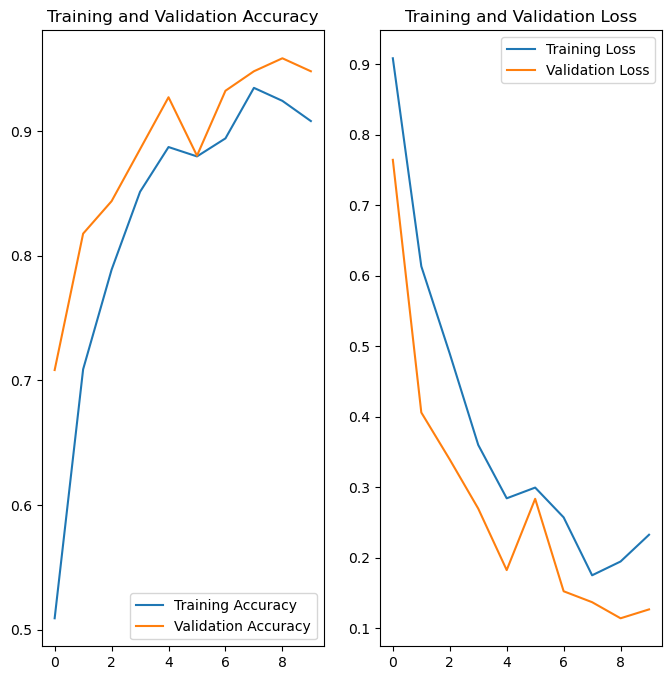

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
predicted label: Potato___healthy


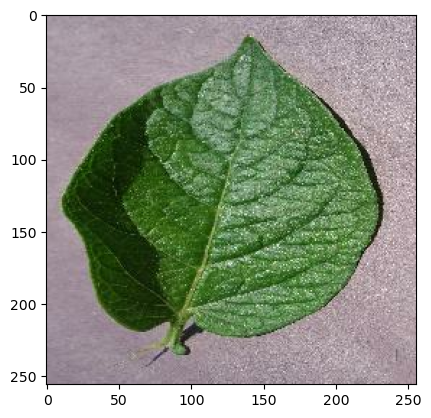

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


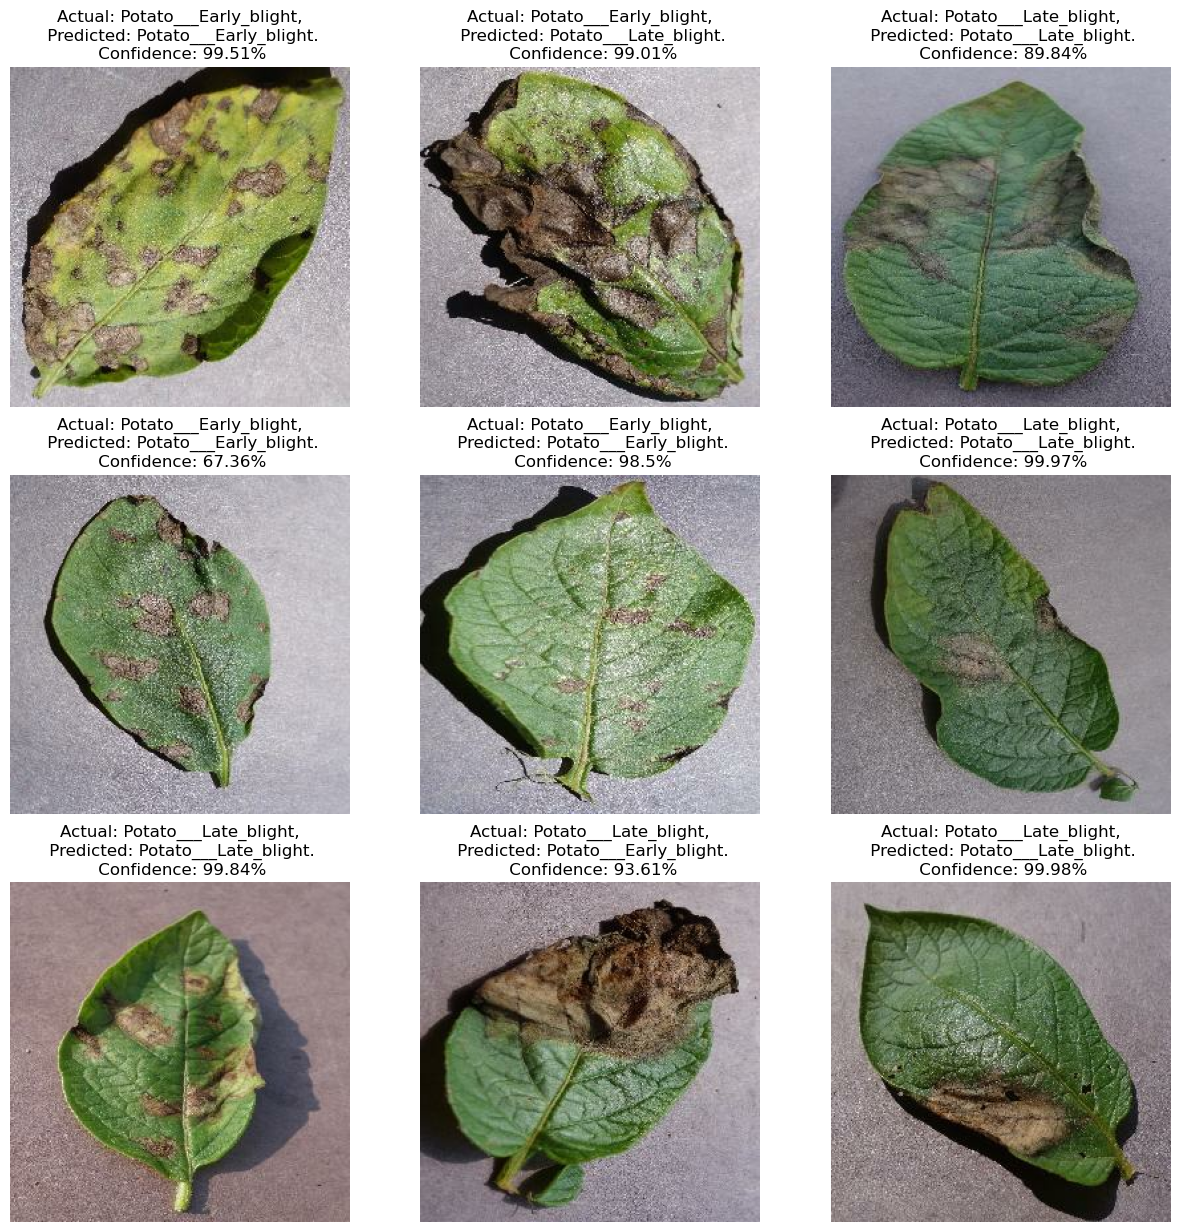

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [2]:
model_version = 1
model.save(r"C:\Users\Maddy\Documents\Python\Data Science\Deep Learning\Potato_Disease\training\model_v{model_version}.keras")